In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import sys

sys.path.append("..")

# Parameters for MC simulation of stock prices

In [3]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity

T = 24        # number of time steps
N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

In [4]:
# make a dataset
starttime = time.time()
np.random.seed(42)

# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 0.14288067817687988 seconds


# Visualization of the MC paths

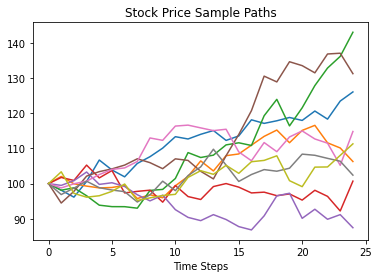

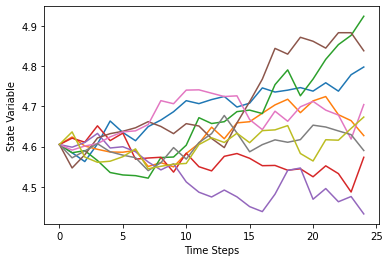

In [5]:
# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)

plt.plot(S.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

In [6]:
def terminal_payoff(ST, K):
    payoff = max(K - ST, 0)
    return payoff

X.shape =  (10000, 25)
X_min, X_max =  4.024923524903037 5.190802775129617
Number of points k =  17


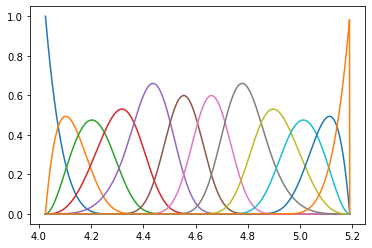

<Figure size 432x288 with 0 Axes>

In [8]:
import bspline
import bspline.splinelab as splinelab
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
        
f = plt.figure()
# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)


In [10]:
# generate case-study data
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()
# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)


num_basis =  12
dim data_mat_t =  (25, 10000, 12)
Computational time: 24.174860954284668 seconds


# DP(Dynamic Programming) solution for QLBS¶


In [18]:
risk_lambda = 0.001 # risk aversion
K = 100             # option stike  

# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):

    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat
 
# note that the delta_S_hat is a global variable, you need to generate outside the function_B_vec function
        
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat=delta_S_hat, 
                   S=S, 
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
 
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)
    return B_vec


In [19]:
# compute the A matrix and B vector as preparation of calculating option value 
reg_param = 1e-3
np.random.seed(42)

A_mat = function_A_vec(T-1, delta_S_hat, data_mat_t, reg_param)
idx_row = np.random.randint(low=0, high=A_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=A_mat.shape[1], size=50)


part_1 = list(A_mat[idx_row, idx_col])
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)


# Compute optimal hedge and portfolio value¶


In [20]:
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3 # free parameter
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    
    # coefficients for expansions of the optimal action
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])
    
a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')

endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')


Computational time: 0.2084212303161621 seconds


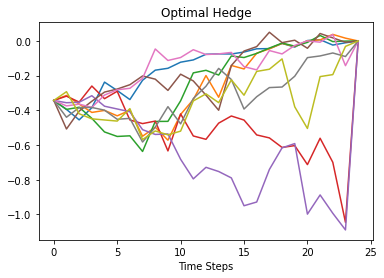

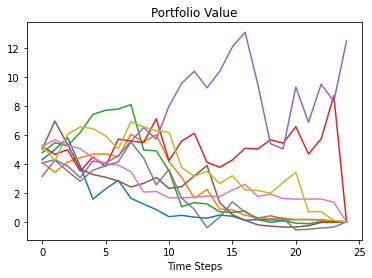

In [21]:
# plot 10 paths
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()
